In [1]:
import os
import pandas as pd
import re 
import string
import nltk #pip install nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download("punkt")

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import TweetTokenizer,word_tokenize

import preprocessor as p #pip install tweet-preprocessor
import contractions #pip install contractions

 
from langdetect import detect #pip install langdetect
from prettytable import PrettyTable, ALL #pip install PrettyTable
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/lucia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lucia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/lucia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#Count rows in a csv file
def get_n_rows(file_path):
    df = pd.read_csv(file_path)
    return len(df)

#Trova il linguaggio
def detect_en(text):
    try:
        lang = detect(text)
        return lang
    except:
        return 'en' #default se non riesce a rilevare la lingua

In [3]:
#Merging all the csv files into one
source = './scraper_new/files/'
destination = './doc'

#Creating merged.csv with header
data = {'username': [],
        'date': [],
        'text': []}

df = pd.DataFrame(data)

file_name = '/merged.csv'
df.to_csv(destination + file_name, index=False, header=True)

#Merging all the csv files into one
for file in os.listdir(source):
    if file.endswith(".csv"):
        df = pd.read_csv(source + file) #leggo il csv nel dataframe
        
        #Controllo il linguaggio  dei file
        df['language'] = df['text'].apply(detect_en)
        
        #Righe che vado ad eliminare
        deleted_rows = df[df['language'] != 'en']
        deleted_rows.to_csv('./doc/deleted_rows.csv', mode='a', header=not os.path.exists('deleted_rows.csv'), index=False)
            
        #Tengo solo la lingua inglese
        df = df[df['language'] == 'en']
        # Rimuovo la colonna language (serviva solo per identificare)
        df.drop(columns=['language'], inplace=True)

        #Salvo il file            
        df.to_csv(destination + '/merged.csv', mode='a', header=False, index=False)
        

In [3]:
#PREPROCESSING
stop_words = set(stopwords.words('english'))

additional_stopwords = ['breaking', 'report' ,'new'] #parole usate all'inizio di articoli
stop_words.update(additional_stopwords)
#print(stop_words)

lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer =  TweetTokenizer()

#Funzione per la pulizia del testo
def cleaning(text):
    try:
        #1) Removing URLs, emojis, mentions, hashtags, RESERVED WORDS (RT, FAV), SMILEYS, NUMBERS
        p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.RESERVED, p.OPT.SMILEY, p.OPT.NUMBER)
        text = p.clean(text)
        
        #2) Removing more than 1 space
        text = ' '.join(text.split())
        
        #3) text in lowecase
        text = text.lower()
        
        #4) Normalizzare parole in forma contratta: isn't -> is not
        text = ' '.join([contractions.fix(word) for word in text.split()])
        
        #5) Rimozione punteggiature 
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        
        #5.5) Rimozione parole contenenti numeri
        pattern = r'\b\w*\d\w*\b'
        text = re.sub(pattern, '', text)
        
        #6) Rimozione caratteri singoli
        pattern = r'\b\w\b' #pattern to match single character words
        text = re.sub(pattern, '', text)
        
        #7) Rimozione stopwords
        text = " ".join([word for word in text.split() if word not in stop_words])
        
        #8) Lemmatization (trasformo le parole alla forma base: says -> say. Trasformazioni abbastanza leggere: dal plurale al singolare)
        lemming = ' '.join([(lemmatizer.lemmatize(w)) for w in word_tokenize((text))])
        
        #9) Stemming
        stemmer = PorterStemmer()
        # Apply stemming to each word and join them into a single string
        stemming = ' '.join([stemmer.stem(w) for w in word_tokenize((text))])
    
        #https://www.datacamp.com/tutorial/stemming-lemmatization-python
        
        #10) Non tengo parole con meno di 5 caratteri
        if len(text) < 6:
            return '','',''
        
    except:
        print("Error in cleaning function with: ", text)
        return '', '', ''  #Elimino la riga

    
    return text, lemming, stemming


In [4]:

source_merged = './doc/merged.csv'
destination_cleaned = './doc/cleaned.csv'

new_data = {'username': [],
        'date': [],
        'text': [],
        'cleaned_text': [],
        'lemmatized_text': [],
        'stemmed_text': []}


#Pre-processing
df = pd.read_csv(source_merged)

tot_rows = 0
for index, row in df.iterrows():
    #Cleaning
    cleaned_text, lemming, stemming = cleaning(row['text'])
    
    #Saving
    if cleaned_text == '' or cleaned_text in new_data['cleaned_text']: #Skippo se il testo è uguale a quello di un altro tweet!
        continue
    
    #per leggibilità testo senza spazi:
    try:
        text_n = ' '.join(row['text'].split())
    except:
        text_n = row['text']
        
    new_data['username'].append(row['username'])
    new_data['date'].append(row['date'])
    new_data['text'].append(text_n) #Elimino gli spazi multipli per leggibilità
    new_data['cleaned_text'].append(cleaned_text)
    new_data['lemmatized_text'].append(lemming)
    new_data['stemmed_text'].append(stemming)
    tot_rows += 1
    
    #Mi fermo al raggiungimento di 70000 righe precise
    if tot_rows == 70000:
        break
    
new_df = pd.DataFrame(new_data)
new_df.to_csv(destination_cleaned, index=False, header=True)


Error in cleaning function with:  nan
Error in cleaning function with:  nan
Error in cleaning function with:  nan
Error in cleaning function with:  nan
Error in cleaning function with:  nan
Error in cleaning function with:  nan
Error in cleaning function with:  nan
Error in cleaning function with:  nan


In [5]:
print("Numero righe file merged finale: ", get_n_rows("./doc/merged.csv"))
print("Numero di righe eliminate dal file iniziale: ", get_n_rows('./doc/deleted_rows.csv'))
print("Numero righe file pulito: ", get_n_rows("./doc/cleaned.csv"))

Numero righe file merged finale:  85565
Numero di righe eliminate dal file iniziale:  7515
Numero righe file pulito:  70000


In [6]:
#Show some tweets
def show_tweet(n = 'all'):
    df = pd.read_csv("./doc/cleaned.csv")
    table = PrettyTable(['user','date','text','cleaned','lemmed','stemmed'])
    table.max_width = 35
    table.hrules= ALL
    if n == 'all':
        for row in df.itertuples(index=False):
            table.add_row(row)
    else:
        random_rows = df.sample(n , random_state=42)
        for row in random_rows.itertuples(index=False):
            table.add_row(row)

    # Stampa la tabella PrettyTable
    print(table)
        
show_tweet(100)

+-----------------+---------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+
|       user      |            date           |                 text                |               cleaned               |                lemmed               |               stemmed               |
+-----------------+---------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+
|   SenDuckworth  | 2023-03-02 00:48:02+00:00 |  Now, let’s do better and build on  |   let us better andbuild democrats  |    let u better andbuild democrat   |   let us better andbuild democrat   |
|                 |                           | Democrats' Inflation Reduction Act. |  inflation reduction actlet us cap  |   inflation reduction actlet u cap  |   inflat reduct actlet us cap cost  |


<Axes: ylabel='username'>

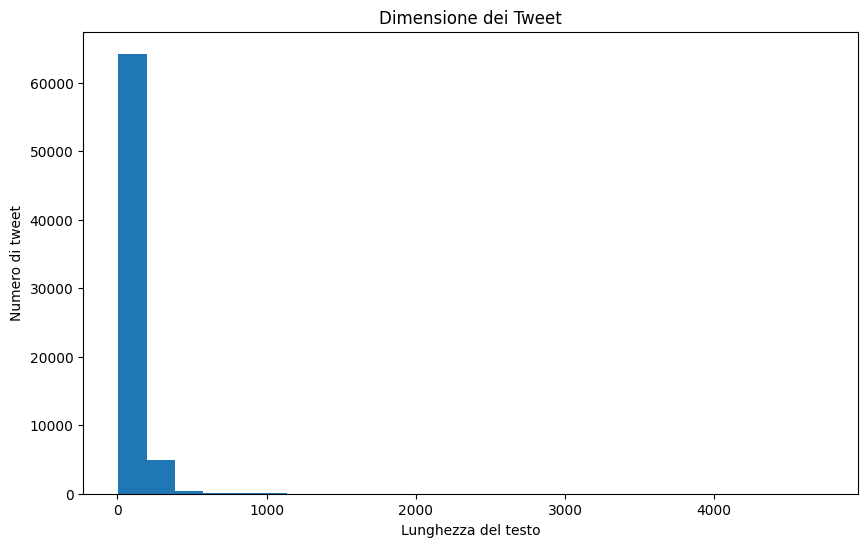

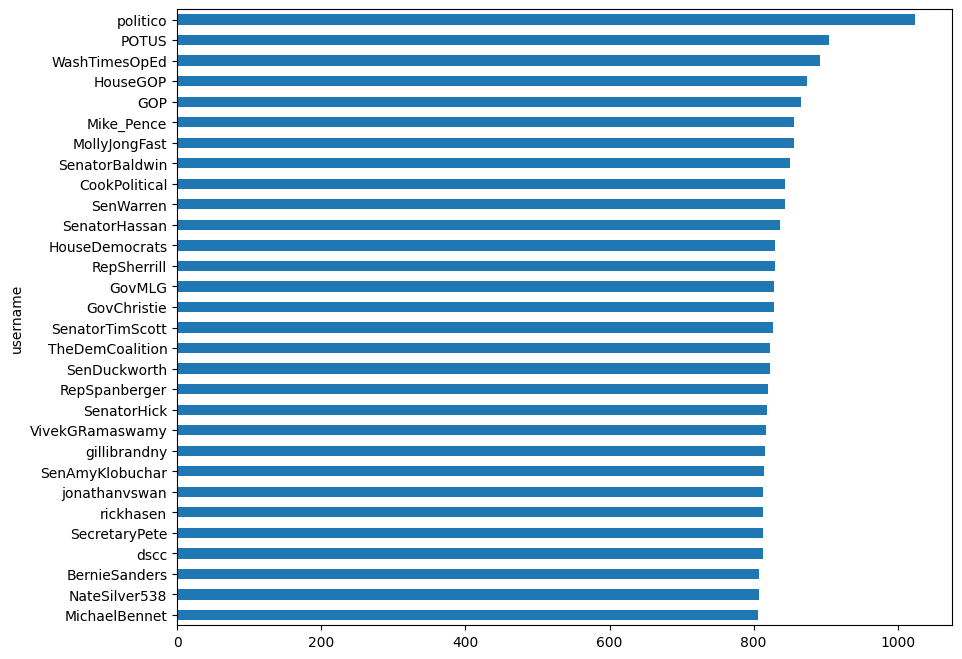

In [7]:
#exploratory data analysis (EDA)
df_clean = pd.read_csv('./doc/cleaned.csv')

#1) Dimensione dei tweet
plt.figure(figsize=(10,6))
doc_lens = [len(str(d)) if isinstance(d, str) else 0 for d in df_clean['cleaned_text']]


plt.hist(doc_lens, bins = 25,   range=(min(doc_lens), max(doc_lens)))
plt.title('Dimensione dei Tweet')
plt.ylabel('Numero di tweet')
plt.xlabel('Lunghezza del testo')

#2) 30 account da cui provengono più tweet
plt.figure(figsize=(10,8))
df_clean['username'].value_counts().head(30).sort_values(ascending=True).plot(kind='barh')
